In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
from textblob import TextBlob
import re

from pytrends.request import TrendReq
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from wordcloud import WordCloud


NEWS_API_KEY = "Your Key" 

#cleaning function
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = [w for w in text.split() if w not in ENGLISH_STOP_WORDS]
    return " ".join(words)



In [2]:
#Google Trends function
def fetch_google_trends(keywords, timeframe="2014-01-01 2025-10-01"):
    pytrends = TrendReq(hl="en-US", tz=360)
    pytrends.build_payload(keywords, timeframe=timeframe, geo="")
    df = pytrends.interest_over_time()
    if "isPartial" in df.columns:
        df = df.drop(columns=["isPartial"])
    return df

google_trends_df = fetch_google_trends(["Bitcoin trust", "Bitcoin scam"])
time.sleep(2)

In [4]:
# NEWS API function
def fetch_news(query, from_date, to_date, page=1):
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": "en",
        "from": from_date,
        "to": to_date,
        "sortBy": "relevancy",
        "page": page,
        "apiKey": NEWS_API_KEY
    }
    response = requests.get(url, params=params).json()
    articles = []
    for a in response.get("articles", []):
        articles.append({
            "date": a.get("publishedAt"),
            "text": a.get("description"),
            "source": a.get("source", {}).get("name", "")
        })
    df = pd.DataFrame(articles)
    df = df.dropna(subset=["text"])
    df["clean_text"] = df["text"].apply(clean_text)
    df["sentiment"] = df["text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

today = datetime.today().strftime("%Y-%m-%d")
week_ago = (datetime.today() - timedelta(days=7)).strftime("%Y-%m-%d")

df_news = fetch_news(
    "Bitcoin",
    week_ago,
    today
)


In [5]:
#Topic Modeling
docs = df_news["clean_text"].tolist()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, language="english")
topics, probs = topic_model.fit_transform(docs)
df_news["topic"] = topics


In [6]:
#Label Topics
def label_topic(words):
    words = " ".join(words).lower()
    positive = ["trust", "adoption", "safe", "secure", "growth", "bullish", "good", "reputation"]
    negative = ["scam", "hack", "fraud", "risk", "loss", "bearish", "bad", "fraudulent"]
    if any(p in words for p in positive):
        return "trust"
    elif any(n in words for n in negative):
        return "untrust"
    else:
        return "neutral"


topic_info = topic_model.get_topic_info()
topic_labels = {}
for topic_num in topic_info["Topic"]:
    if topic_num == -1:
        topic_labels[topic_num] = "neutral"
    else:
        words = [w[0] for w in topic_model.get_topic(topic_num)]
        topic_labels[topic_num] = label_topic(words)

df_news["topic_label"] = df_news["topic"].map(topic_labels)

<Figure size 1000x500 with 0 Axes>

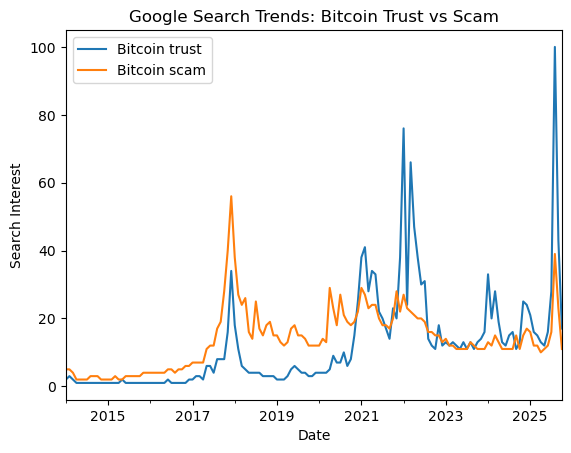

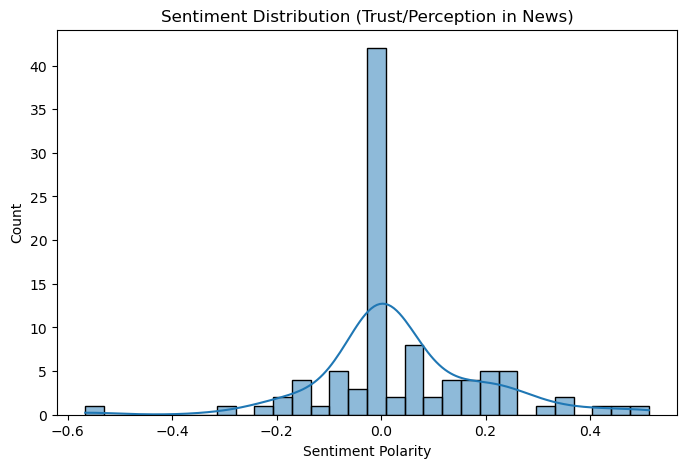

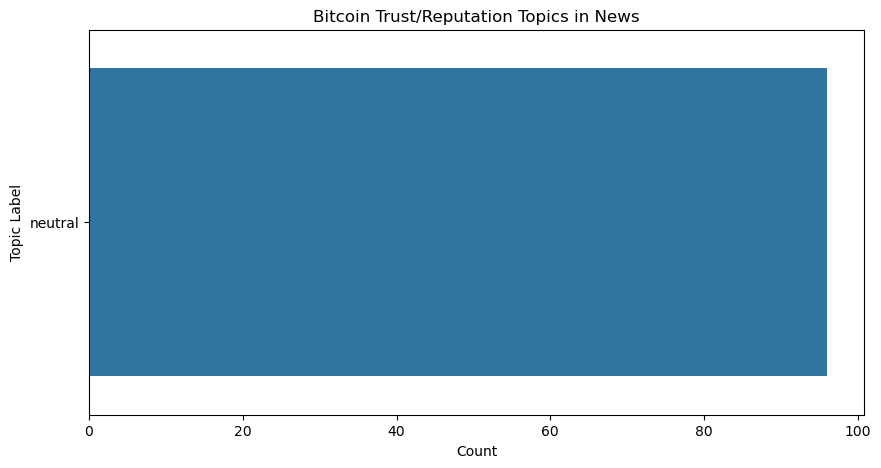

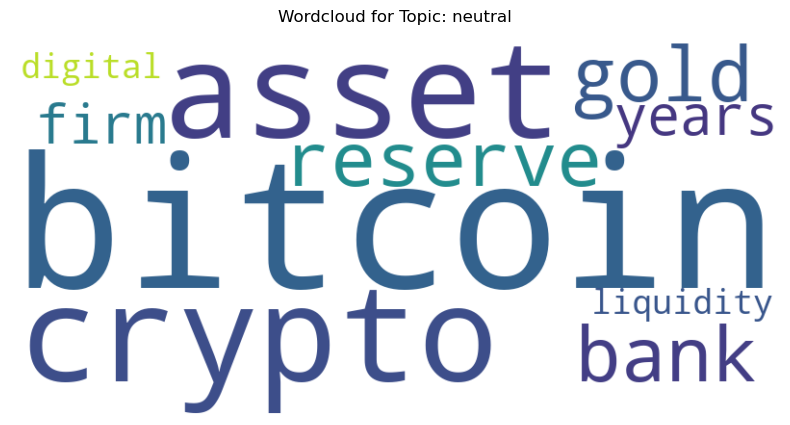

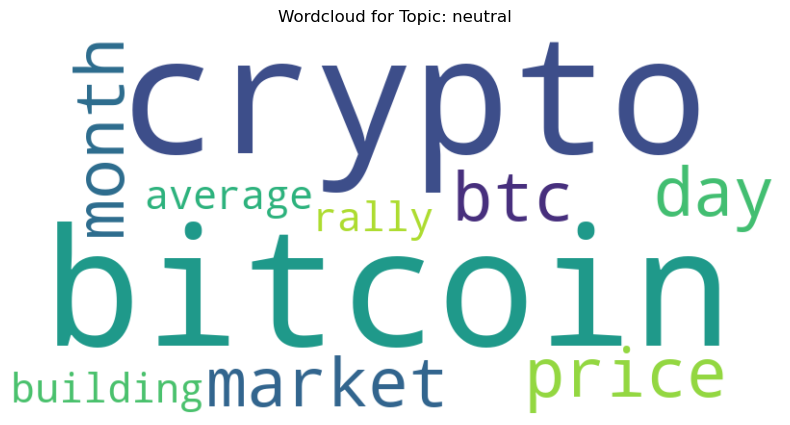

In [ ]:
#Visualization
#Google Trends
plt.figure(figsize=(10,5))
google_trends_df.plot()
plt.title("Google Search Trends: Bitcoin Trust vs Scam")
plt.ylabel("Search Interest")
plt.xlabel("Date")
plt.show()

#Sentiment distribution
plt.figure(figsize=(8,5))
sns.histplot(df_news["sentiment"], bins=30, kde=True)
plt.title("Sentiment Distribution (Trust/Perception in News)")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Count")
plt.show()

#Topic label counts
plt.figure(figsize=(10,5))
sns.countplot(y="topic_label", data=df_news, order=df_news["topic_label"].value_counts().index)
plt.title("Bitcoin Trust/Reputation Topics in News")
plt.xlabel("Count")
plt.ylabel("Topic Label")
plt.show()

#Wordclouds per topic
for topic_num, label in topic_labels.items():
    if topic_num == -1:
        continue
    words = " ".join([w[0] for w in topic_model.get_topic(topic_num)])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud for Topic: {label}")
    plt.show()

In [8]:
for topic_num in topic_model.get_topic_info()["Topic"]:
    if topic_num == -1:
        continue
    words = [w[0] for w in topic_model.get_topic(topic_num)]
    print(f"Topic {topic_num}: {words}")


Topic 0: ['bitcoin', 'crypto', 'asset', 'reserve', 'bank', 'gold', 'years', 'firm', 'liquidity', 'digital']
Topic 1: ['bitcoin', 'crypto', 'price', 'btc', 'day', 'month', 'market', 'building', 'average', 'rally']


This API is limited to only a few days, which doesn't help in concluding the analysis.

<Figure size 1200x600 with 0 Axes>

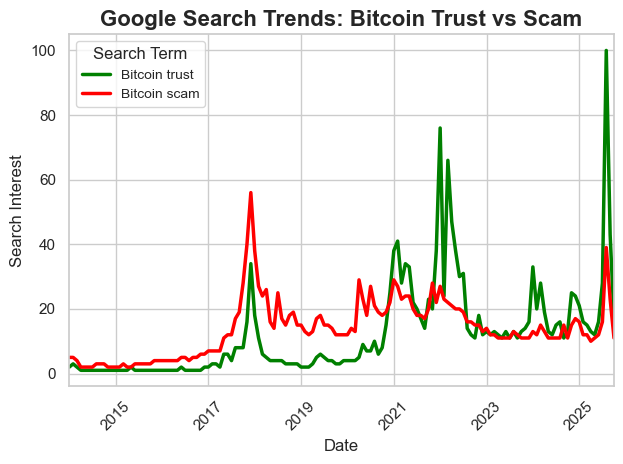

In [10]:
sns.set(style="whitegrid")

plt.figure(figsize=(12,6))

ax = google_trends_df.plot(
    linewidth=2.5,
    color=['green', 'red']  # Trust = green, Scam = red
)

plt.title("Google Search Trends: Bitcoin Trust vs Scam", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Interest", fontsize=12)

plt.legend(title='Search Term', fontsize=10, title_fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In the early days, interest in Bitcoin was low and often associated with scams, before both sentiments spiked in 2017 during the Bitcoin boom. By 2021, the perception began shifting toward trust, culminating in a strong surge in 2025 that reflects the growing confidence and interest in Bitcoin.